In [ ]:
#!pip install gym[box2d]
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 83 kB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

In [ ]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [ ]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions, fc1_dims=256, fc2_dims=256):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.pi = nn.Linear(fc2_dims, n_actions)
        self.v = nn.Linear(fc2_dims, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        pi = self.pi(x)
        v = self.v(x)

        return (pi, v)

In [ ]:
class Agent():
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, 
                 gamma=0.99):
        self.gamma = gamma
        self.lr = lr
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.actor_critic = ActorCriticNetwork(lr, input_dims, n_actions, 
                                               fc1_dims, fc2_dims)
        self.log_prob = None

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor_critic.device)
        probabilities, _ = self.actor_critic.forward(state)
        probabilities = F.softmax(probabilities, dim=1)
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob

        return action.item()

    def learn(self, state, reward, state_, done):
        self.actor_critic.optimizer.zero_grad()

        state = T.tensor([state], dtype=T.float).to(self.actor_critic.device)
        state_ = T.tensor([state_], dtype=T.float).to(self.actor_critic.device)
        reward = T.tensor(reward, dtype=T.float).to(self.actor_critic.device)

        _, critic_value = self.actor_critic.forward(state)
        _, critic_value_ = self.actor_critic.forward(state_)

        delta = reward + self.gamma*critic_value_*(1-int(done)) - critic_value

        actor_loss = -self.log_prob*delta
        critic_loss = delta**2

        (actor_loss + critic_loss).backward()
        self.actor_critic.optimizer.step()

In [ ]:
env = gym.make('CartPole-v1')
agent = Agent(gamma=0.99, lr=5e-6, input_dims=[4], n_actions=2, fc1_dims=2048, fc2_dims=1536)
n_games = 1000



scores = []
for i in range(n_games):
    done = False
    observation = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.learn(observation, reward, observation_, done)
        observation = observation_
    scores.append(score)

    avg_score = np.mean(scores[-100:])
    print('episode ', i, 'score %.1f' % score,'average score %.1f' % avg_score)
    #if avg_score > 195:
      #break



/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/ipy

episode  0 score 11.0 average score 11.0
episode  1 score 18.0 average score 14.5
episode  2 score 26.0 average score 18.3
episode  3 score 12.0 average score 16.8
episode  4 score 15.0 average score 16.4
episode  5 score 34.0 average score 19.3
episode  6 score 14.0 average score 18.6
episode  7 score 13.0 average score 17.9
episode  8 score 19.0 average score 18.0
episode  9 score 13.0 average score 17.5
episode  10 score 12.0 average score 17.0
episode  11 score 26.0 average score 17.8
episode  12 score 14.0 average score 17.5
episode  13 score 17.0 average score 17.4
episode  14 score 23.0 average score 17.8
episode  15 score 13.0 average score 17.5
episode  16 score 23.0 average score 17.8
episode  17 score 33.0 average score 18.7
episode  18 score 29.0 average score 19.2
episode  19 score 49.0 average score 20.7
episode  20 score 29.0 average score 21.1
episode  21 score 22.0 average score 21.1
episode  22 score 13.0 average score 20.8
episode  23 score 17.0 average score 20.6
ep

Done


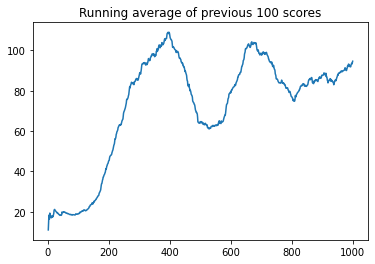

In [ ]:
fname = 'actor_critic_no_experience_replay_cartpole'
figure_file = fname + '.png'
csv_file = fname +'.csv'

x = [i+1 for i in range(len(scores))]
plot_learning_curve(x, scores, figure_file)

with open(csv_file, 'w') as fp:
    for item in scores:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')